In [1]:
# Importing modules
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import umap.umap_ as umap
import numba
import pyarrow.dataset as ds
import matplotlib.pylab as plt
from tqdm.notebook import tqdm
import hdbscan

In [2]:
# Pandas display options (personal preference)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)

In [3]:
# Matplotlib options
plt.rcParams['xtick.top'] = 'True'
plt.rcParams['ytick.right'] = 'True'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = 6
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['ytick.major.size'] = 6
plt.rcParams['xtick.minor.visible'] = 'True'
plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['ytick.minor.visible'] = 'True'
plt.rcParams['axes.linewidth'] = 1.2

plt.rcParams['figure.figsize'] = [10,8]
font = {'size'   : 20}
plt.rc('font', **font)

In [4]:
# Importing the G09 parquet file
dataset = ds.dataset("../../data/WD10/WD10_2p4.parquet", format="parquet")
table = dataset.to_table()

# Setting uberID as index
df = table.to_pandas().set_index('uberID')
df.index=df.index.astype('int64')

del dataset,table

In [5]:
# Getting rid of weird spaces in the class column
df=df.replace({'class': {'ambiguous ': 'ambiguous',
                         'star      ': 'star', 
                         'galaxy    ': 'galaxy', 
                         'artefact  ':'artefact'}})

In [6]:
# Making a number of cuts: magnitude, mask, starmask and removing artefacts
df=df[(df['mag_Zt']<22) & 
      (df['mask']==0) & 
      (df['starmask']==0) & 
      (df['class']!='artefact')&
      (df['duplicate']==0)
]

In [7]:
# Getting a 1/10 subset of the data (for the purpose of this tutorial)
# df=df[::10]

In [8]:
# Define the bands and their corresponding flux columns
bands = ['g', 'r', 'i', 'Z', 'Y', 'J', 'H', 'K']
tot_suffix = 't'
col_suffix = 'c'

# Loop through each band and calculate magnitudes for both 'tot' and 'col'
for band in bands:
    df[f'mag_{band}_tot'] = 8.9 - 2.5 * np.log10(df[f'flux_{band}t'])
    df[f'mag_{band}_col'] = 8.9 - 2.5 * np.log10(df[f'flux_{band}c'])

/home/ir-band1/1-research/venvs/umap_3-11/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/ir-band1/1-research/venvs/umap_3-11/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/ir-band1/1-research/venvs/umap_3-11/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/ir-band1/1-research/venvs/umap_3-11/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/ir-band1/1-research/venvs/umap_3-11/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, me

In [9]:
# Generate lists for 'tot' and 'col' features
mag_tot_features = [f'mag_{band}_tot' for band in bands]
mag_col_features = [f'mag_{band}_col' for band in bands]

# Making a list of all features we will use for UMAP
features = mag_tot_features + mag_col_features + ['R50', 'R90', 'axrat']

# Colours list
colours = mag_col_features

In [10]:
# Removing all rows of the dataframe with NaN values
df_lim=df[features]

df=df.drop(df_lim[df_lim.isnull().any(axis=1)].index)

del df_lim

In [11]:
# Making an empty array ready to put features
X = np.zeros((len(df), 39))

In [12]:
# Filling the first 36 features as each unique colours
l=0
for i in tqdm(range(len(colours))):
    for j in range(i+1,len(colours)):
        X[:,l]=(df[colours[i]] - df[colours[j]])
        l+=1

  0%|          | 0/8 [00:00<?, ?it/s]

In [13]:
# Filling the remaining features (total fluxes and size information)
X[:,28]=(df['mag_g_tot'])
X[:,29]=(df['mag_r_tot'])
X[:,30]=(df['mag_i_tot'])
X[:,31]=(df['mag_Z_tot'])
X[:,32]=(df['mag_Y_tot'])
X[:,33]=(df['mag_J_tot'])
X[:,34]=(df['mag_H_tot'])
X[:,35]=(df['mag_K_tot'])
X[:,36]=np.log10(df['R50'])
X[:,37]=df['R50']/df['R90']
X[:,38]=df['axrat']

In [14]:
# Scaling features to 0 mean and unit variance
X = StandardScaler().fit_transform(X)

In [15]:
# Applying UMAP to our features
# These parameters have been fairly tuned, but there's definitely some room for some more tinkering
X_umap=umap.UMAP(
    n_neighbors=200,
    min_dist=0,
    n_components=10,
    random_state=42,
).fit_transform(X)
print('Done')

/home/ir-band1/1-research/venvs/umap_3-11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ir-band1/1-research/venvs/umap_3-11/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Done


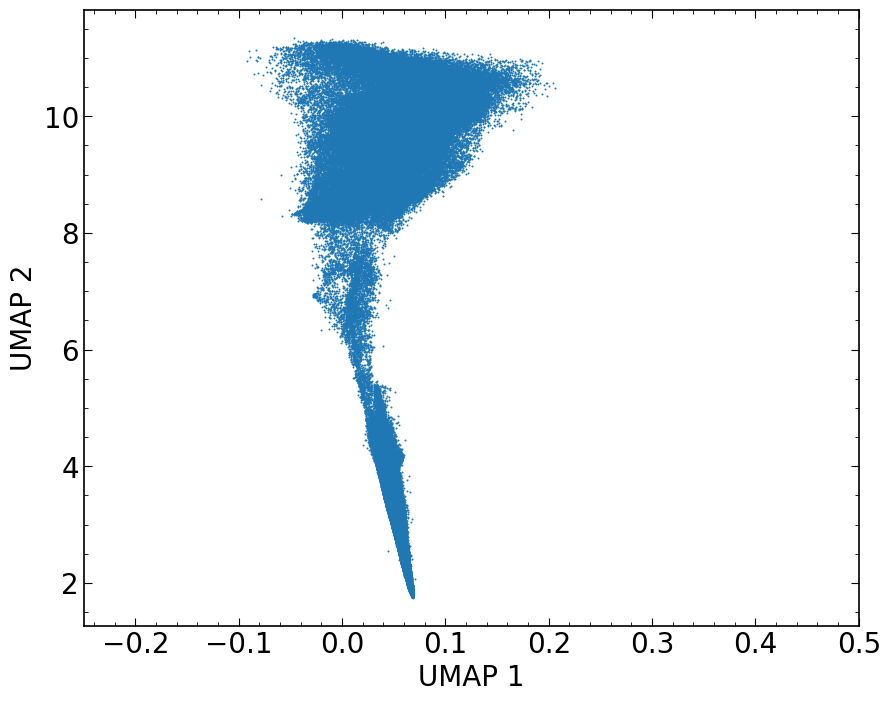

In [16]:
# Plotting the first two UMAP features
plt.scatter(X_umap[:,0],X_umap[:,1],s=2,linewidth=0)
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.xlim(-.25,.5)
plt.show()

In [17]:
# Loop through UMAP components and assign them to the DataFrame
for i in range(10):
    df[f'umap{i+1}'] = X_umap[:, i]

In [18]:
# Defining labels as stars, galaxies, ambiguous
labels=np.unique(df['class'])
colors=['black','red','blue']

  0%|          | 0/3 [00:00<?, ?it/s]

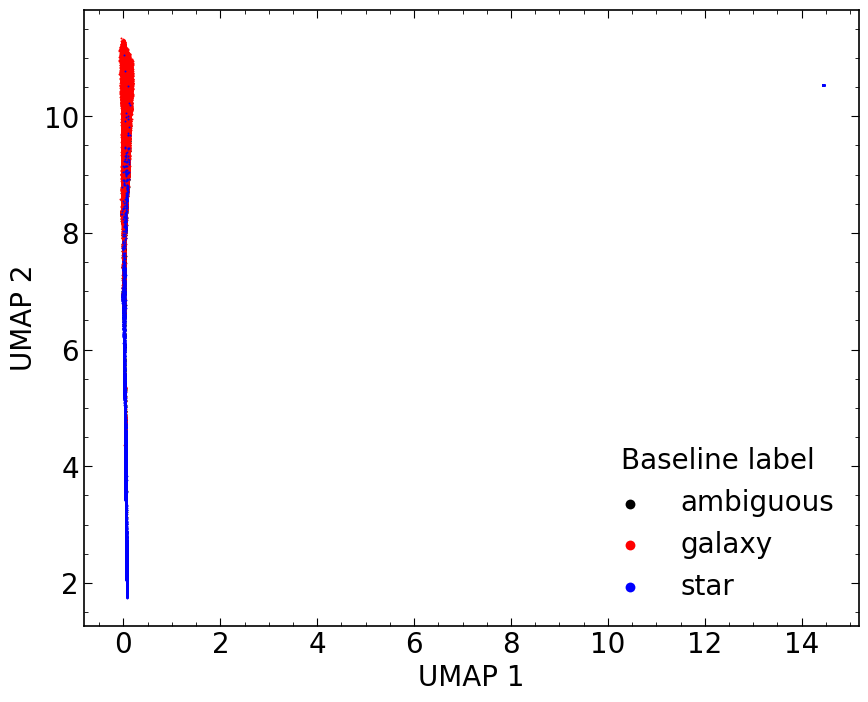

In [19]:
# Plotting UMAP 1 and UMAP 2 with baseline label as colour
for i in tqdm(range(len(labels))):
    plt.scatter(df[df['class']==labels[i]]['umap1'],
                df[df['class']==labels[i]]['umap2'],
                s=2,label=labels[i],c=colors[i],linewidth=0)

lgnd=plt.legend(frameon=False,title='Baseline label')

lgnd.legend_handles[0]._sizes = [50]
lgnd.legend_handles[1]._sizes = [50]
lgnd.legend_handles[2]._sizes = [50]
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')

plt.savefig('../plots/WD10/UMAP_no_u_baseline_WD10.jpg',bbox_inches='tight',dpi=100,facecolor='white')


plt.show()

In [20]:
# HDBSCAN clustering the UMAP feautre space
# min_samples should be probably 1000 when you apply to the entirety of the sample
clusterer = hdbscan.HDBSCAN(core_dist_n_jobs=-1,min_samples=100).fit(X_umap)

/home/ir-band1/1-research/venvs/umap_3-11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ir-band1/1-research/venvs/umap_3-11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [21]:
# Setting the output of HDBSCAN into the dataframe
df['cluster_label']=clusterer.labels_

In [22]:
# Defining the unique cluster labels
clusterer_labels=np.unique(df['cluster_label'])

In [23]:
# For each HDBSCAN label, see how the baseline classification corresponds
for label in clusterer_labels:
    print(label,':')
    print('galaxy:',len(df[(df['cluster_label']==label) & (df['class']=='galaxy')]))
    print('star:',len(df[(df['cluster_label']==label) & (df['class']=='star')]))
    print('ambiguous:',len(df[(df['cluster_label']==label) & (df['class']=='ambiguous')]))

-1 :
galaxy: 1162
star: 181
ambiguous: 162
0 :
galaxy: 4195
star: 13805
ambiguous: 5820
1 :
galaxy: 75496
star: 170
ambiguous: 3064


In [27]:
# Manually defining the HDBSCAN outputs to galaxy or star, based on the previous cell
df['cluster_label']=df['cluster_label'].replace([0], 'galaxy')
df['cluster_label']=df['cluster_label'].replace([1], 'star')
df['cluster_label']=df['cluster_label'].replace([2], 'star')

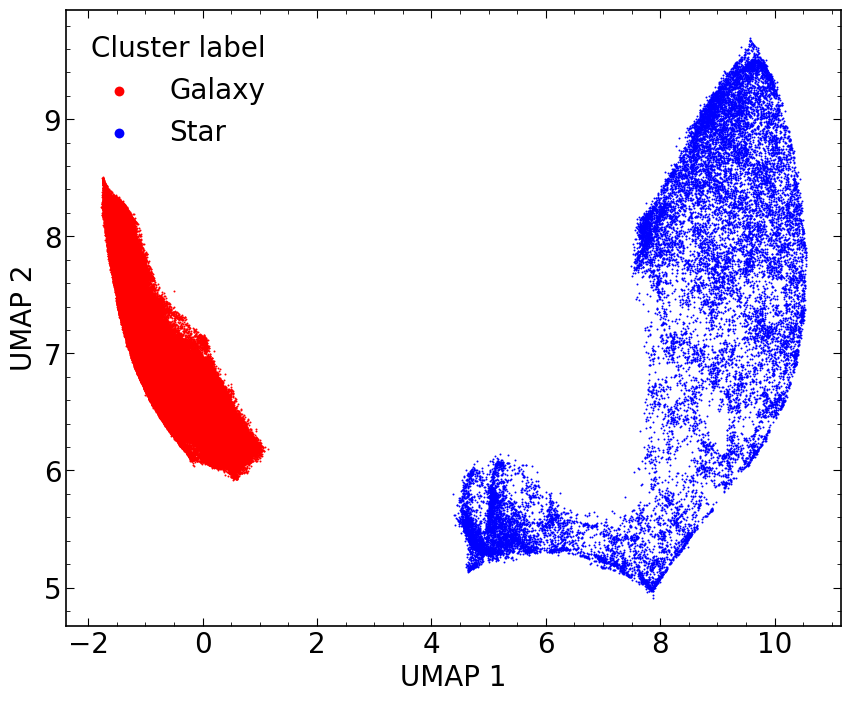

In [ ]:
# Plotting UMAP 1 and UMAP 2 again with cluster label. Should correspond roughly with previous plot
plt.scatter(df[df['cluster_label']=='galaxy']['umap1'],
            df[df['cluster_label']=='galaxy']['umap2'],
            s=2,linewidth=0,label='Galaxy',c='red')

plt.scatter(df[df['cluster_label']=='star']['umap1'],
            df[df['cluster_label']=='star']['umap2'],
            s=2,linewidth=0,label='Star',c='blue')

lgnd=plt.legend(frameon=False,title='Cluster label')

lgnd.legend_handles[0]._sizes = [50]
lgnd.legend_handles[1]._sizes = [50]
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')

plt.savefig('../plots/WD10/WD10_UMAP_no_u_cluster.jpg',bbox_inches='tight',dpi=100,facecolor='white')


plt.show()

In [ ]:
#Saving labels
df.to_csv('../../data/WD10/WD10_no_u.csv')

In [30]:
df

,FrameName,FrameID,segID,xmax,ymax,censep,RAcen,Deccen,RAmax,Decmax,RAGAIA_r,RAGAIA,DecGAIA,DecGAIA_r,RAGAIA_r_cen,DecGAIA_r_cen,RAcen_gt,Deccen_gt,RAmax_gt,Decmax_gt,RAcen_rt,Deccen_rt,RAmax_rt,Decmax_rt,RAcen_Zt,Deccen_Zt,RAmax_Zt,Decmax_Zt,sky_mean,skyRMS_mean,log10seeing,log10seeing_r,log10seeing_i,log10seeing_Z,log10seeing_Y,mag,EBV,R50,R50_gt,R50_rt,R50_Yt,R50_Jt,R50_Ht,R90,R100,N100,axrat,ang,groupID,Ngroup,mag_app_Zt,mag_Zt,mag_app_gt,mag_app_rt,mag_app_it,mag_app_Yt,flux_ut,flux_err_ut,flux_ut_uncorrected,flux_err_ut_uncorrected,flux_gt,flux_err_gt,flux_gt_uncorrected,flux_err_gt_uncorrected,flux_rt,flux_err_rt,flux_rt_uncorrected,flux_err_rt_uncorrected,flux_it,flux_err_it,flux_it_uncorrected,flux_err_it_uncorrected,flux_Zt,flux_err_Zt,flux_Zt_uncorrected,flux_err_Zt_uncorrected,flux_Yt,flux_err_Yt,flux_Yt_uncorrected,flux_err_Yt_uncorrected,flux_Jt,flux_err_Jt,flux_Jt_uncorrected,flux_err_Jt_uncorrected,flux_Ht,flux_err_Ht,flux_Ht_uncorrected,flux_err_Ht_uncorrected,flux_Kt,flux_err_Kt,flux_Kt_uncorrected,flux_err_Kt_uncorrected,flux_W1t,flux_err_W1t,flux_W1t_uncorrected,flux_err_W1t_uncorrected,flux_W2t,flux_err_W2t,flux_W2t_uncorrected,flux_err_W2t_uncorrected,flux_uc,flux_err_uc,flux_gc,flux_err_gc,flux_rc,flux_err_rc,flux_ic,flux_err_ic,flux_Zc,flux_err_Zc,flux_Yc,flux_err_Yc,flux_Jc,flux_err_Jc,flux_Hc,flux_err_Hc,flux_Kc,flux_err_Kc,flux_W1c,flux_err_W1c,flux_W2c,flux_err_W2c,mask,starmask,starscol,starssize,class,noOPT_r,noOPT_i,noIR_Z,noIR_Y,duplicate,mag_Zc,mag_Zt_fake,mag_g_tot,mag_g_col,mag_r_tot,mag_r_col,mag_i_tot,mag_i_col,mag_Z_tot,mag_Z_col,mag_Y_tot,mag_Y_col,mag_J_tot,mag_J_col,mag_H_tot,mag_H_col,mag_K_tot,mag_K_col,umap1,umap2,umap3,umap4,umap5,umap6,umap7,umap8,umap9,umap10,cluster_label
uberID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
36971195800254,waves_postprocessed_37.0_-3.5.rds,3697.0,28,11957.5,253.5,8276.934819,36.585878,-4.062106,36.585862,-4.062085,36.585896,36.585896,-4.062111,-4.062111,36.585931,-4.062128,36.585918,-4.062081,36.585862,-4.062085,36.585897,-4.062102,36.585862,-4.062085,36.585880,-4.062105,36.585862,-4.062085,-0.002751,0.003172,-0.162571,-0.094759,-0.164494,-0.161807,-0.153093,15.489770,0.033257,0.670359,0.980934,0.849038,0.661603,0.601284,0.565228,2.173057,11.660159,4442,0.935971,73.598735,28,10,16.045604,15.467905,18.671152,17.160600,16.335561,15.793864,3.380947e-05,2.207446e-06,2.917651e-05,1.904956e-06,2.949221e-04,8.025781e-07,2.636068e-04,7.173589e-07,1.028585e-03,9.746135e-07,9.482575e-04,8.985013e-07,0.001730,3.315048e-06,0.001623,3.110929e-06,0.002360,2.875208e-06,0.002250,2.741703e-06,0.002961,6.667548e-06,0.002853,6.424377e-06,0.002982,3.570833e-06,0.002903,3.476267e-06,0.003652,0.000004,0.003589,0.000004,0.002888,5.177355e-06,0.002855,5.119185e-06,1.286970e-03,8.837989e-07,1.279061e-03,8.783678e-07,0.000670,3.140175e-06,0.000667,3.126760e-06,2.929688e-05,1.597023e-06,2.939962e-04,5.770235e-07,1.022830e-03,6.629288e-07,1.721307e-03,1.980520e-06,2.350237e-03,1.182835e-06,2.947524e-03,2.627846e-06,2.969536e-03,1.530534e-06,0.003634,1.619906e-06,2.867813e-03,2.629908e-06,1.218787e-03,3.587485e-07,6.390815e-04,1.514522e-06,0.0,0.0,3.0,3.0,star,0.0,0.0,0.0,0.0,0.0,15.472221,0,17.725732,17.729146,16.369400,16.375491,15.804908,15.810354,15.467905,15.472221,15.221484,15.226356,15.213602,15.218278,14.993633,14.999033,15.248535,15.256123,9.627107,6.129471,0.378513,7.644282,5.226652,4.982826,6.122746,5.788310,6.564748,5.094060,star
36971303600016,waves_postprocessed_37.0_-3.5.rds,3697.0,35,13035.5,15.5,9218.422967,36.495768,-4.081879,36.495802,-4.081864,36.495836,36.495836,-4.081890,-4.082057,36.495867,-4.081996,36.495937,-4.081900,36.495801,-4.082031,36.495832,-4.081970,36.495801,-4.082031,36.495769,-4.081879,36.495802,-4.081864,-0.002159,0.003427,-0.162571,-0.094759,-0.164494,-0.161807,-0.153093,15.846100,0.037839,0.650567,1.031790,0.872398,0.626406,0

In [35]:
# Importing the G09 parquet file
dataset = ds.dataset("../data/WD01_2p4.parquet", format="parquet")
table = dataset.to_table()

# Setting uberID as index
df_untuched = table.to_pandas().set_index('uberID')
df_untuched.index=df_untuched.index.astype('int64')

del dataset,table

In [36]:
df_untuched

,FrameName,FrameID,segID,xmax,ymax,censep,RAcen,Deccen,RAmax,Decmax,RAGAIA_r,RAGAIA,DecGAIA,DecGAIA_r,RAGAIA_r_cen,DecGAIA_r_cen,RAcen_gt,Deccen_gt,RAmax_gt,Decmax_gt,RAcen_rt,Deccen_rt,RAmax_rt,Decmax_rt,RAcen_Zt,Deccen_Zt,RAmax_Zt,Decmax_Zt,sky_mean,skyRMS_mean,log10seeing,log10seeing_r,log10seeing_i,log10seeing_Z,log10seeing_Y,mag,EBV,R50,R50_gt,R50_rt,R50_Yt,R50_Jt,R50_Ht,R90,R100,N100,axrat,ang,groupID,Ngroup,mag_app_Zt,mag_Zt,mag_app_gt,mag_app_rt,mag_app_it,mag_app_Yt,flux_ut,flux_err_ut,flux_ut_uncorrected,flux_err_ut_uncorrected,flux_gt,flux_err_gt,flux_gt_uncorrected,flux_err_gt_uncorrected,flux_rt,flux_err_rt,flux_rt_uncorrected,flux_err_rt_uncorrected,flux_it,flux_err_it,flux_it_uncorrected,flux_err_it_uncorrected,flux_Zt,flux_err_Zt,flux_Zt_uncorrected,flux_err_Zt_uncorrected,flux_Yt,flux_err_Yt,flux_Yt_uncorrected,flux_err_Yt_uncorrected,flux_Jt,flux_err_Jt,flux_Jt_uncorrected,flux_err_Jt_uncorrected,flux_Ht,flux_err_Ht,flux_Ht_uncorrected,flux_err_Ht_uncorrected,flux_Kt,flux_err_Kt,flux_Kt_uncorrected,flux_err_Kt_uncorrected,flux_W1t,flux_err_W1t,flux_W1t_uncorrected,flux_err_W1t_uncorrected,flux_W2t,flux_err_W2t,flux_W2t_uncorrected,flux_err_W2t_uncorrected,flux_uc,flux_err_uc,flux_gc,flux_err_gc,flux_rc,flux_err_rc,flux_ic,flux_err_ic,flux_Zc,flux_err_Zc,flux_Yc,flux_err_Yc,flux_Jc,flux_err_Jc,flux_Hc,flux_err_Hc,flux_Kc,flux_err_Kc,flux_W1c,flux_err_W1c,flux_W2c,flux_err_W2c,mask,starmask,starscol,starssize,class,noOPT_r,noOPT_i,noIR_Z,noIR_Y,duplicate,mag_Zc,mag_Zt_fake
uberID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
11580600903055,waves_postprocessed_11.3_-42.5.rds,1158.0,1,6008.5,3054.5,3145.504093,11.462416,-42.828601,11.462660,-42.828733,11.463401,11.462719,-42.828764,-42.828597,11.462004,-42.828891,11.461963,-42.828876,11.463114,-42.828482,11.461944,-42.828860,11.463341,-42.828566,11.462415,-42.828601,11.462660,-42.828733,0.025699,0.037499,0.081047,-0.094455,-0.087670,0.082202,-0.049899,11.997384,0.014986,1.438525,3.082451,3.749246,1.124479,1.303405,1.312843,3.708285,18.051080,10477,0.921135,135.858764,1,9,13.932546,11.972832,18.023463,17.828234,17.248688,12.976512,0.002530,6.206462e-06,0.002367,5.807691e-06,0.002685,5.226821e-06,0.002553,4.969019e-06,0.004384,5.930013e-06,0.004226,5.716673e-06,0.006767,7.969752e-06,0.006576,7.744769e-06,0.059002,2.729970e-05,0.057751,2.672105e-05,0.080600,6.146334e-05,0.079262,6.044296e-05,6.607038e-02,4.793017e-05,6.527614e-02,4.735399e-05,0.066233,0.000103,0.065718,0.000102,5.923750e-02,0.000074,5.893666e-02,0.000074,3.035076e-02,2.141536e-05,3.026658e-02,2.135596e-05,1.618351e-02,1.657543e-05,1.615232e-02,1.654349e-05,0.002529,3.744790e-06,0.002667,3.378609e-06,0.004329,2.884057e-06,0.006723,5.604130e-06,5.882290e-02,1.309550e-05,8.040857e-02,3.228867e-05,6.583443e-02,2.398826e-05,6.604557e-02,6.431349e-05,5.905900e-02,4.659333e-05,2.982420e-02,7.301693e-06,1.587891e-02,5.901532e-06,1.0,1.0,3.0,3.0,star,0.0,0.0,0.0,0.0,0.0,11.976134,0
11581308200245,waves_postprocessed_11.3_-42.5.rds,1158.0,2,13081.5,244.5,9101.278427,10.656416,-43.060561,10.656406,-43.060846,10.657382,10.656466,-43.060877,-43.060549,10.658661,-43.062008,10.658606,-43.061976,10.657206,-43.060684,10.658601,-43.061977,10.657322,-43.060518,10.656418,-43.060564,10.656406,-43.060846,0.020354,0.026642,0.081047,-0.094455,-0.087670,0.082202,-0.049899,11.928943,0.010880,1.654159,3.826787,3.874431,1.195000,1.473322,1.370075,4.045527,18.311171,10782,0.921213,48.756404,2,9,14.243075,11.910703,17.825412,17.388039,16.819559,13.241161,0.006870,7.629825e-06,0.006547,7.270700e-06,0.004072,9.355923e-06,0.003925,9.018588e-06,0.005917,4.964686e-06,0.005761,4.834365e-06,0.009052,2.483929e-05,0.008866,2.432823e-05,0.062477,2.236151e-05,0.061513,2.201640e-05,0.075170,4.357346e-05,0.074262,4.304708e-05,5.969877e-02,5.018827e-05,5.917689e-02,4.974953e-05,0.053250,0.000036,0.052949,0.000036,4.947577e-02,0.000063,4.929323e-02,0.000063